# CVAE
Again, this autoencoder is based on a keras example - https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder_deconv.py. Again, I'll tidy it up soon and bring the style more closely in line with my own, along with descriptions of how and why everything works the way it does...

Essentially it's a mix of the variational autoencoder from nb 03 and the methods used in the classification problem to learn actual image features. Convolutional layers are clever.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import *
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.models import Sequential

Using TensorFlow backend.


In [2]:
data = np.load('../data/full%2Fnumpy_bitmap%2Fdog.npy')

In [3]:
data = data.reshape(-1, 28, 28, 1) / 255.0
print(data.max())
print(data.min())
print(data.shape)

1.0
0.0
(152159, 28, 28, 1)


In [4]:
data = data[:5000]
batch_size=20

In [8]:
x = Input(shape=(28, 28, 1))
conv_1 = Conv2D(1,
                kernel_size=(2, 2),
                padding='same', activation='relu')(x)
conv_2 = Conv2D(64,
                kernel_size=(2, 2),
                padding='same', activation='relu',
                strides=(2, 2))(conv_1)
conv_3 = Conv2D(64,
                kernel_size=(3, 3),
                padding='same', activation='relu',
                strides=1)(conv_2)
conv_4 = Conv2D(64,
                kernel_size=(3, 3),
                padding='same', activation='relu',
                strides=1)(conv_3)
flat = Flatten()(conv_4)
hidden = Dense(128, activation='relu')(flat)

z_mean = Dense(2)(hidden)
z_log_var = Dense(2)(hidden)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], 2),
                              mean=0, stddev=1)
    
    return z_mean + K.exp(z_log_var) * epsilon


# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_var])`
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])


# we instantiate these layers separately so as to reuse them later
decoder_hid = Dense(128, activation='relu')
decoder_upsample = Dense(64 * 14 * 14, activation='relu')

if K.image_data_format() == 'channels_first':
    output_shape = (batch_size, 64, 14, 14)
else:
    output_shape = (batch_size, 14, 14, 64)

decoder_reshape = Reshape(output_shape[1:])
decoder_deconv_1 = Conv2DTranspose(64,
                                   kernel_size=(3, 3),
                                   padding='same',
                                   strides=1,
                                   activation='relu')
decoder_deconv_2 = Conv2DTranspose(64,
                                   kernel_size=(3, 3),
                                   padding='same',
                                   strides=1,
                                   activation='relu')

output_shape = (batch_size, 29, 29, 64)

decoder_deconv_3_upsamp = Conv2DTranspose(64,
                                          kernel_size=(3, 3),
                                          strides=(2, 2),
                                          padding='valid',
                                          activation='relu')
decoder_mean_squash = Conv2D(1,
                             kernel_size=2,
                             padding='valid',
                             activation='sigmoid')

hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded = decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
deconv_2_decoded = decoder_deconv_2(deconv_1_decoded)
x_decoded_relu = decoder_deconv_3_upsamp(deconv_2_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)


# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean_squash):
        x = K.flatten(x)
        x_decoded_mean_squash = K.flatten(x_decoded_mean_squash)
        xent_loss = 28 * 28 * metrics.binary_crossentropy(x, x_decoded_mean_squash)
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean_squash = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean_squash)
        self.add_loss(loss, inputs=inputs)
        # We don't use this output.
        return x


y = CustomVariationalLayer()([x, x_decoded_mean_squash])
vae = Model(x, y)
vae.compile(optimizer='adam', loss=None)

/home/harrisonpim/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:103: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.


In [9]:
vae.fit(data,
        shuffle=True,
        epochs=5,
        batch_size=batch_size,
        validation_split=1/3)

Train on 3333 samples, validate on 1667 samples
Epoch 1/5
3333/3333 [==============================] - 84s - loss: 306.1410 - val_loss: 270.9554
Epoch 2/5
3333/3333 [==============================] - 53s - loss: 265.6504 - val_loss: 258.2877
Epoch 3/5
3333/3333 [==============================] - 52s - loss: 258.9218 - val_loss: 254.9073
Epoch 4/5
3333/3333 [==============================] - 51s - loss: 256.6823 - val_loss: 252.8377
Epoch 5/5
3333/3333 [==============================] - 51s - loss: 255.4700 - val_loss: 253.1506


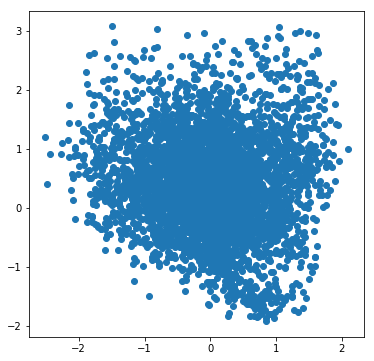

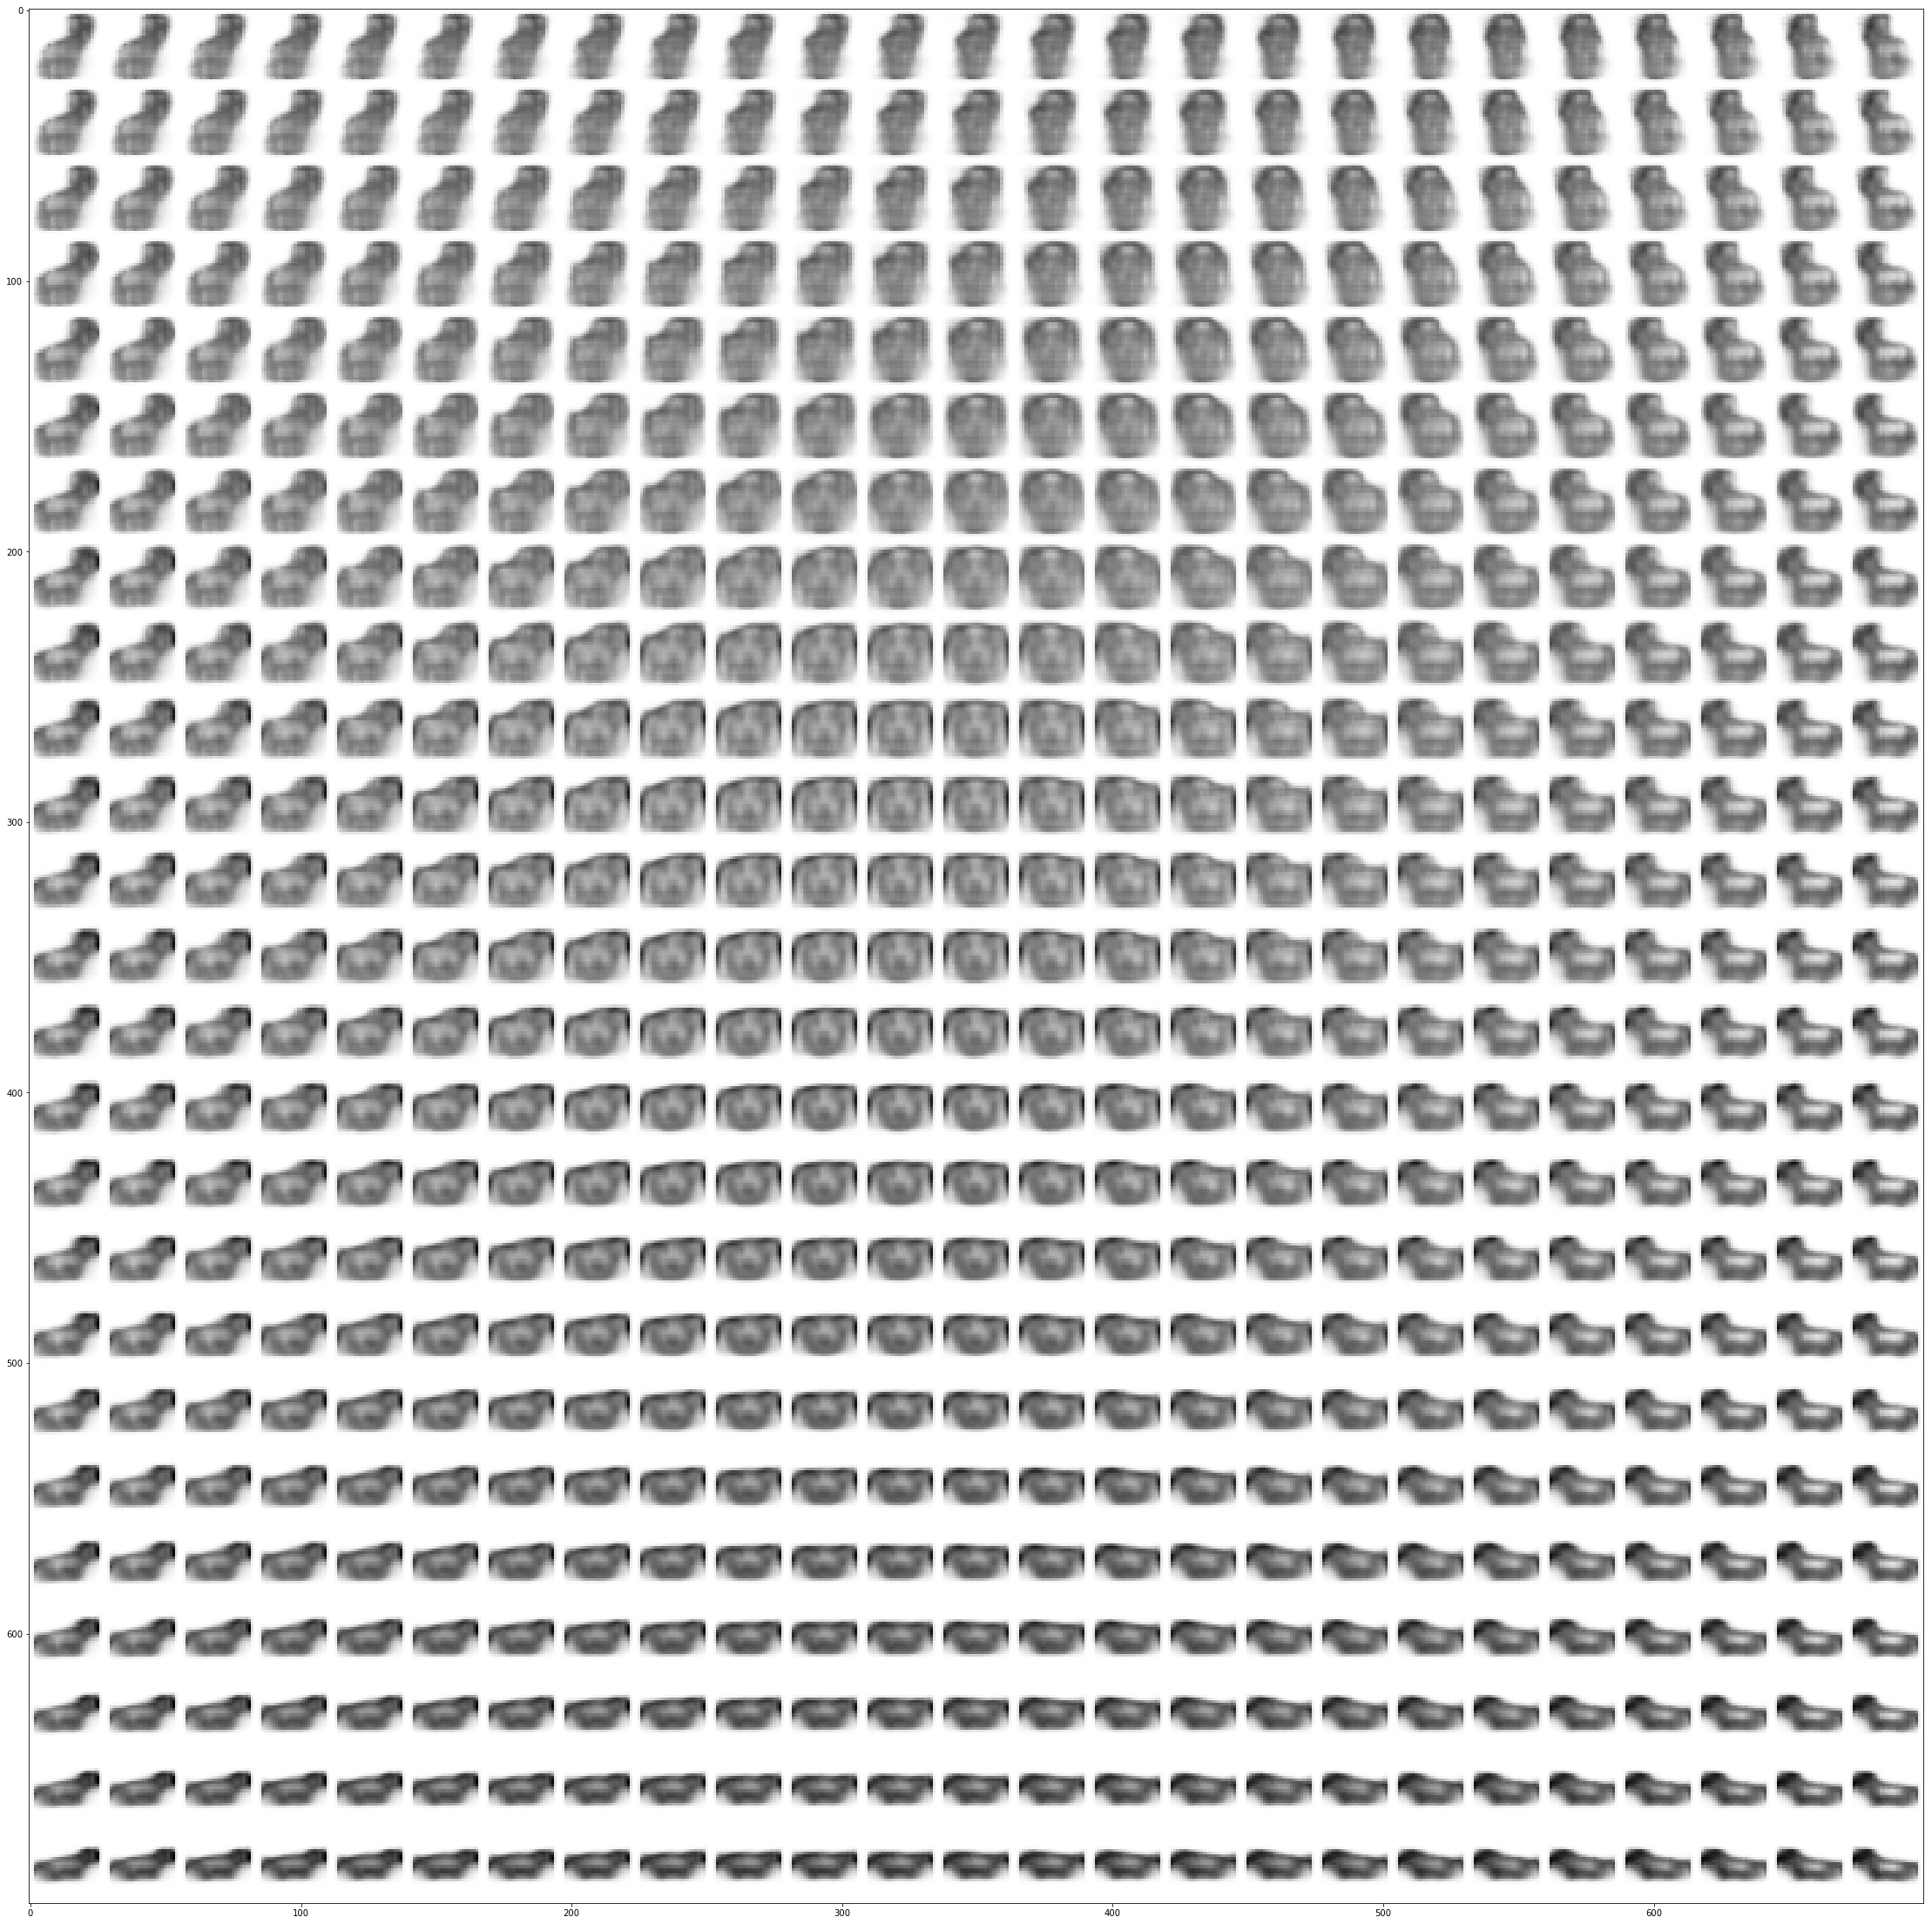

In [10]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
data_encoded = encoder.predict(data, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(data_encoded[:, 0], data_encoded[:, 1])
plt.show()

# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(2,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_deconv_2_decoded = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_relu = decoder_deconv_3_upsamp(_deconv_2_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash)

# display a 2D manifold of the digits
n = 25  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = generator.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(40, 40))
plt.imshow(figure, cmap='Greys')
plt.show()